<h1><center>準備一個Dataframe (dataset)</center></h1>

In [1]:
from pycaret.datasets import get_data
dataset = get_data('credit')
print(dataset.shape)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


(24000, 24)


<h1><center>資料切割</center></h1>

In [2]:
#dataset 全部資料 ; data_unseen 外部測試集 ; data 訓練集(訓練&內部測試)

data = dataset.sample(frac=0.95, random_state=30678)          #抽95%(24000*0.95=22800)作訓練集
data_unseen = dataset.drop(data.index)                        #drop掉這95%(24000-22800=1200)，剩餘5%作外部測試集

data.reset_index(inplace=True, drop=True)                     #訓練集重新reset index
data_unseen.reset_index(inplace=True, drop=True)              #測試集重新reset index

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (22800, 24)
Unseen Data For Predictions (1200, 24)


<h1><center>預處理</center></h1>

In [3]:
from pycaret.classification import *
exp_clf102 = setup(data = data, target = 'default', session_id=30678,
                  normalize = True, #歸一化
                  transformation = True, #資料變換
                  ignore_low_variance = True, #忽略低方差的特徵因子
                  remove_multicollinearity = True, multicollinearity_threshold = 0.95, #共線性
                  bin_numeric_features = ['LIMIT_BAL', 'AGE'], #分箱(因兩因子數字特徵和目標變量之間的相關性較弱)
                  group_features = [['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],
                                   ['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']], #特徵分群
                  log_experiment = True, experiment_name = 'credit1',log_plots = True) #log報告

,Description,Value
0,session_id,30678
1,Target,default
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(22800, 24)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


2021/12/21 15:45:49 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



<h1><center>查看各演算法初步訓練集效能</center></h1>

In [4]:
top3 = compare_models(n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8234,0.0000,0.3528,0.6878,0.4661,0.3732,0.4032,0.0380
lda,Linear Discriminant Analysis,0.8221,0.7737,0.3695,0.6687,0.4757,0.3791,0.4035,0.1560
svm,SVM - Linear Kernel,0.8217,0.0000,0.3264,0.6975,0.4445,0.3545,0.3910,0.1260
gbc,Gradient Boosting Classifier,0.8216,0.7792,0.3537,0.6759,0.4641,0.3694,0.3975,2.1360
lr,Logistic Regression,0.8215,0.7745,0.3416,0.6841,0.4554,0.3626,0.3941,0.6630
ada,Ada Boost Classifier,0.8204,0.7762,0.3264,0.6879,0.4426,0.3514,0.3862,0.5670
catboost,CatBoost Classifier,0.8199,0.7780,0.3606,0.6616,0.4665,0.3693,0.3941,4.0150
lightgbm,Light Gradient Boosting Machine,0.8193,0.7763,0.3528,0.6631,0.4604,0.3638,0.3901,0.2020
rf,Random Forest Classifier,0.8140,0.7604,0.3457,0.6375,0.4481,0.3479,0.3716,0.7880
et,Extra Trees Classifier,0.8127,0.7498,0.3546,0.6281,0.4528,0.3501,0.3713,0.6620


In [5]:
print(type(top3)) #前三名方法參數配置
top3

<class 'list'>


[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, normalize=False, random_state=30678,
                 solver='auto', tol=0.001),
 LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                            solver='svd', store_covariance=False, tol=0.0001),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
               early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
               l1_ratio=0.15, learning_rate='optimal', loss='hinge',
               max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
               power_t=0.5, random_state=30678, shuffle=True, tol=0.001,
               validation_fraction=0.1, verbose=0, warm_start=False)]

<h1><center>Auto最佳化參數</center></h1>

In [6]:
dt = create_model('dt', fold = 5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7278,0.6165,0.4198,0.3871,0.4027,0.2268,0.2271
1,0.7240,0.6036,0.3888,0.3733,0.3809,0.2034,0.2035
2,0.7271,0.6039,0.3845,0.3775,0.3810,0.2060,0.2060
3,0.7240,0.6087,0.4017,0.3763,0.3886,0.2106,0.2108
4,0.7249,0.6065,0.3888,0.3748,0.3817,0.2048,0.2049
Mean,0.7255,0.6078,0.3967,0.3778,0.3870,0.2103,0.2105
SD,0.0016,0.0047,0.0129,0.0048,0.0084,0.0086,0.0087


In [7]:
rf = create_model('rf', round = 2)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.81,0.76,0.36,0.63,0.46,0.36,0.38
1,0.81,0.76,0.34,0.63,0.44,0.34,0.37
2,0.83,0.78,0.38,0.71,0.50,0.41,0.43
3,0.81,0.75,0.35,0.60,0.44,0.33,0.35
4,0.81,0.75,0.34,0.62,0.44,0.34,0.36
5,0.82,0.76,0.35,0.67,0.46,0.36,0.39
6,0.81,0.78,0.33,0.64,0.44,0.34,0.36
7,0.81,0.75,0.34,0.60,0.44,0.33,0.35
8,0.81,0.76,0.34,0.64,0.45,0.35,0.37
9,0.81,0.75,0.32,0.64,0.43,0.33,0.36


In [8]:
tuned_rf = tune_model(rf, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7531,0.7614,0.6132,0.4524,0.5207,0.3595,0.3670
1,0.7713,0.7708,0.6046,0.4817,0.5362,0.3870,0.3914
2,0.7744,0.7746,0.6189,0.4876,0.5455,0.3983,0.4033
3,0.7607,0.7828,0.5817,0.4624,0.5152,0.3591,0.3632
4,0.7751,0.7704,0.6103,0.4885,0.5427,0.3959,0.4003
5,0.7701,0.7776,0.5931,0.4792,0.5301,0.3801,0.3839
6,0.7826,0.7798,0.6034,0.5012,0.5476,0.4061,0.4091
7,0.7525,0.7686,0.6207,0.4509,0.5224,0.3610,0.3693
8,0.7744,0.7828,0.5891,0.4858,0.5325,0.3856,0.3887
9,0.7668,0.7714,0.6006,0.4729,0.5291,0.3770,0.3818


In [9]:
tuned_rf2 = tune_model(rf, optimize = 'Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7130,0.7483,0.6390,0.4018,0.4934,0.3074,0.3235
1,0.7224,0.7620,0.6705,0.4164,0.5137,0.3340,0.3526
2,0.7325,0.7693,0.6619,0.4278,0.5197,0.3459,0.3618
3,0.7337,0.7618,0.6304,0.4264,0.5087,0.3352,0.3473
4,0.7187,0.7550,0.6103,0.4049,0.4869,0.3038,0.3160
5,0.7306,0.7682,0.6304,0.4223,0.5057,0.3304,0.3429
6,0.7262,0.7625,0.6322,0.4159,0.5017,0.3239,0.3374
7,0.7049,0.7518,0.6609,0.3945,0.4941,0.3040,0.3242
8,0.7318,0.7682,0.6466,0.4245,0.5125,0.3384,0.3526
9,0.7335,0.7613,0.6552,0.4278,0.5176,0.3446,0.3595


In [10]:
plot_model(tuned_rf, plot = 'parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced
criterion,entropy
max_depth,9
max_features,sqrt
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0001
min_impurity_split,None


In [11]:
plot_model(tuned_rf2, plot = 'parameter')

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,balanced_subsample
criterion,entropy
max_depth,11
max_features,log2
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.005
min_impurity_split,None


<h1><center>Ensemble集成算法，base以dt為例</center></h1>

<h1><center>Bagging</center></h1>

In [12]:
dt  =  create_model ( 'dt' )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7105,0.5974,0.3954,0.3548,0.3740,0.1864,0.1869
1,0.7381,0.6231,0.4155,0.4039,0.4096,0.2414,0.2414
2,0.7494,0.6375,0.4327,0.4278,0.4302,0.2696,0.2696
3,0.7231,0.6030,0.3897,0.3726,0.3810,0.2027,0.2028
4,0.7262,0.5973,0.3639,0.3713,0.3676,0.1929,0.1929
5,0.7193,0.6048,0.4011,0.3694,0.3846,0.2032,0.2035
6,0.7155,0.5952,0.3736,0.3552,0.3641,0.1811,0.1812
7,0.7262,0.6150,0.4167,0.3826,0.3989,0.2220,0.2224
8,0.7262,0.6036,0.3678,0.3710,0.3694,0.1945,0.1945
9,0.7285,0.6100,0.4023,0.3836,0.3927,0.2180,0.2181


In [13]:
# Bagging
bagged_dt  =  ensemble_model ( dt )

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7989,0.7274,0.3410,0.5667,0.4258,0.3129,0.3277
1,0.7945,0.7168,0.3095,0.5538,0.3971,0.2850,0.3025
2,0.8170,0.7419,0.3524,0.6508,0.4572,0.3587,0.3832
3,0.7907,0.6915,0.3037,0.5381,0.3883,0.2737,0.2900
4,0.7951,0.7083,0.3066,0.5573,0.3956,0.2845,0.3029
5,0.7964,0.7113,0.2808,0.5698,0.3762,0.2709,0.2952
6,0.8089,0.7353,0.3305,0.6150,0.4299,0.3274,0.3502
7,0.8039,0.7322,0.3305,0.5897,0.4236,0.3165,0.3358
8,0.8127,0.7237,0.3362,0.6324,0.4390,0.3390,0.3634
9,0.8056,0.7247,0.3362,0.5969,0.4301,0.3238,0.3433


In [14]:
print(bagged_dt)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=30678,

<h1><center>Boosting</center></h1>

In [15]:
#Boosting
boosted_dt = ensemble_model(dt, method = 'Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7713,0.6422,0.3610,0.4701,0.4084,0.2697,0.2733
1,0.7876,0.7093,0.3181,0.5236,0.3957,0.2761,0.2887
2,0.8051,0.6878,0.3983,0.5792,0.4720,0.3575,0.3669
3,0.7788,0.6605,0.3152,0.4911,0.3839,0.2569,0.2663
4,0.7832,0.6496,0.2980,0.5073,0.3755,0.2549,0.2681
5,0.7744,0.6899,0.3467,0.4783,0.4020,0.2673,0.2726
6,0.7845,0.6977,0.3678,0.5079,0.4267,0.2981,0.3040
7,0.7425,0.7042,0.5057,0.4241,0.4613,0.2938,0.2958
8,0.7487,0.6855,0.3707,0.4148,0.3915,0.2338,0.2344
9,0.7793,0.6389,0.3017,0.4907,0.3737,0.2489,0.2597


In [16]:
# n_estimators <-子樹的數量
bagged_dt2 = ensemble_model(dt, n_estimators=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8139,0.7422,0.3725,0.6250,0.4668,0.3627,0.3805
1,0.8076,0.7486,0.3696,0.5972,0.4566,0.3475,0.3623
2,0.8283,0.7653,0.3754,0.7005,0.4888,0.3968,0.4247
3,0.7957,0.7402,0.3352,0.5545,0.4179,0.3030,0.3171
4,0.8108,0.7442,0.3524,0.6181,0.4489,0.3449,0.3647
5,0.8233,0.7572,0.3782,0.6701,0.4835,0.3867,0.4098
6,0.8139,0.7588,0.3362,0.6393,0.4407,0.3417,0.3672
7,0.8095,0.7593,0.3736,0.6019,0.4610,0.3529,0.3677
8,0.8095,0.7622,0.3448,0.6122,0.4412,0.3370,0.3572
9,0.8245,0.7541,0.3822,0.6717,0.4872,0.3908,0.4134


<h1><center>blending</center></h1>

In [17]:
# train individual models to blend
lightgbm = create_model('lightgbm', verbose = False)
dt = create_model('dt', verbose = False)
lr = create_model('lr', verbose = False)

In [18]:
# soft vote
blend_soft = blend_models(estimator_list = [lightgbm, dt, lr], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7945,0.7459,0.3668,0.5447,0.4384,0.3184,0.3277
1,0.8039,0.7578,0.3811,0.5783,0.4594,0.3458,0.3570
2,0.8202,0.7635,0.3868,0.6490,0.4847,0.3842,0.4031
3,0.7901,0.7591,0.3352,0.5318,0.4112,0.2914,0.3029
4,0.8033,0.7445,0.3553,0.5822,0.4413,0.3303,0.3451
5,0.8033,0.7526,0.3610,0.5806,0.4452,0.3335,0.3474
6,0.8051,0.7624,0.3362,0.5939,0.4294,0.3226,0.3416
7,0.7926,0.7595,0.3592,0.5365,0.4303,0.3095,0.3189
8,0.7976,0.7463,0.3477,0.5576,0.4283,0.3133,0.3262
9,0.7994,0.7473,0.3592,0.5631,0.4386,0.3236,0.3358


In [19]:
# hard vote
blend_hard = blend_models(estimator_list = [lightgbm, dt, lr], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8208,0.0000,0.3582,0.6684,0.4664,0.3703,0.3964
1,0.8208,0.0000,0.3553,0.6703,0.4644,0.3688,0.3956
2,0.8352,0.0000,0.3782,0.7416,0.5009,0.4145,0.4482
3,0.8133,0.0000,0.3410,0.6364,0.4440,0.3439,0.3681
4,0.8170,0.0000,0.3381,0.6592,0.4470,0.3507,0.3788
5,0.8258,0.0000,0.3639,0.6940,0.4774,0.3849,0.4138
6,0.8202,0.0000,0.3362,0.6763,0.4491,0.3559,0.3870
7,0.8177,0.0000,0.3649,0.6447,0.4661,0.3661,0.3877
8,0.8177,0.0000,0.3276,0.6667,0.4393,0.3452,0.3764
9,0.8226,0.0000,0.3391,0.6901,0.4547,0.3632,0.3959


In [20]:
# 混合來自 一開始比較出的compare_models 中的 top3 模型
blender_top3 = blend_models(top3)
print(blender_top3.estimators_)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8177,0.0000,0.3582,0.6510,0.4621,0.3633,0.3868
1,0.8239,0.0000,0.3610,0.6848,0.4728,0.3790,0.4071
2,0.8358,0.0000,0.3782,0.7458,0.5019,0.4159,0.4504
3,0.8202,0.0000,0.3553,0.6667,0.4636,0.3674,0.3936
4,0.8177,0.0000,0.3467,0.6576,0.4540,0.3569,0.3833
5,0.8264,0.0000,0.3553,0.7045,0.4724,0.3817,0.4138
6,0.8264,0.0000,0.3621,0.6961,0.4764,0.3845,0.4141
7,0.8133,0.0000,0.3592,0.6250,0.4562,0.3533,0.3730
8,0.8239,0.0000,0.3420,0.6959,0.4586,0.3677,0.4009
9,0.8257,0.0000,0.3391,0.7108,0.4591,0.3704,0.4066


[RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=30678,
                solver='auto', tol=0.001), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=30678, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)]


<h1><center>Stacking</center></h1>

In [21]:
#選取top3 model 為弱分類器
stack_soft = stack_models(top3)
xgboost = create_model('xgboost')
stack_soft2 = stack_models(top3, meta_model=xgboost) #top3為0級模型 xgboost為1級模型


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8070,0.7542,0.3496,0.6010,0.4420,0.3351,0.3531
1,0.8102,0.7547,0.3582,0.6127,0.4521,0.3467,0.3650
2,0.8177,0.7520,0.3553,0.6526,0.4601,0.3617,0.3859
3,0.8076,0.7558,0.3467,0.6050,0.4408,0.3348,0.3538
4,0.8102,0.7538,0.3467,0.6173,0.4440,0.3403,0.3609
5,0.8108,0.7545,0.3610,0.6146,0.4549,0.3496,0.3678
6,0.8189,0.7804,0.3506,0.6595,0.4578,0.3611,0.3871
7,0.8114,0.7477,0.3707,0.6114,0.4615,0.3554,0.3718
8,0.8145,0.7479,0.3420,0.6398,0.4457,0.3464,0.3710
9,0.8169,0.7577,0.3305,0.6609,0.4406,0.3454,0.3751


<h1><center>模型校準</center></h1>

In [22]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8133,0.7563,0.3639,0.6256,0.4601,0.3567,0.3758
1,0.8127,0.7591,0.3381,0.6344,0.4411,0.3409,0.3653
2,0.8302,0.7829,0.3840,0.7053,0.4972,0.4056,0.4327
3,0.8064,0.7513,0.3467,0.5990,0.4392,0.3321,0.3503
4,0.8102,0.7515,0.3381,0.6211,0.4378,0.3354,0.3579
5,0.8195,0.7642,0.3467,0.6685,0.4566,0.3612,0.3892
6,0.8133,0.7753,0.3305,0.6389,0.4356,0.3370,0.3634
7,0.8076,0.7543,0.3420,0.6041,0.4367,0.3313,0.3508
8,0.8145,0.7566,0.3420,0.6398,0.4457,0.3464,0.3710
9,0.8125,0.7523,0.3247,0.6384,0.4305,0.3322,0.3595


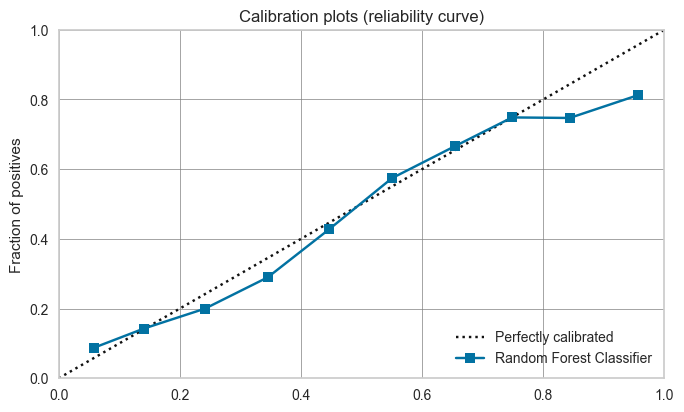

In [23]:
plot_model(rf, plot='calibration')

In [24]:
calibrated_rf = calibrate_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8158,0.7627,0.3467,0.6471,0.4515,0.3527,0.3776
1,0.8120,0.7618,0.3238,0.6384,0.4297,0.3312,0.3586
2,0.8377,0.7824,0.3754,0.7616,0.5029,0.4190,0.4565
3,0.8108,0.7597,0.3295,0.6284,0.4323,0.3318,0.3567
4,0.8095,0.7629,0.3152,0.6286,0.4198,0.3206,0.3480
5,0.8202,0.7727,0.3266,0.6867,0.4427,0.3513,0.3858
6,0.8139,0.7770,0.3247,0.6457,0.4321,0.3351,0.3635
7,0.8127,0.7660,0.3362,0.6324,0.4390,0.3390,0.3634
8,0.8152,0.7659,0.3190,0.6568,0.4294,0.3345,0.3657
9,0.8113,0.7624,0.2989,0.6460,0.4086,0.3140,0.3471


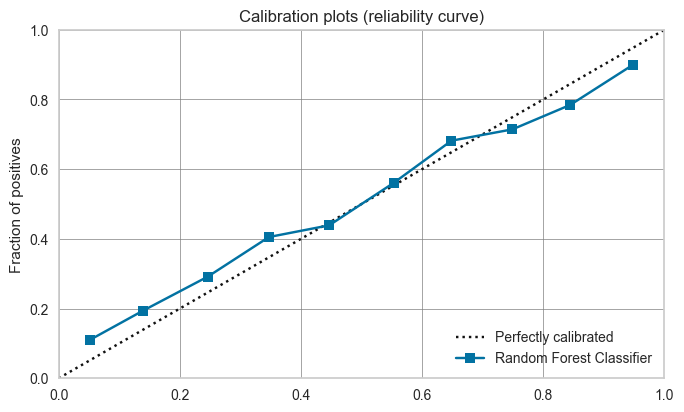

In [49]:
plot_model(calibrated_rf, plot='calibration')

In [50]:
!mlflow ui

^C
